In [ ]:
!pip install tensorflow-gpu==2.0.0

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.0.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/PGAA08_Deep_Learning/Code Files/6. Weather image Classification ")
!dir

6.\ Weather\ Image\ Classification\ with\ Regularisation.ipynb	dataset.zip
dataset


In [ ]:
# !pip install patool

In [ ]:
# # take longer time to run
# import patoolib
# patoolib.extract_archive("dataset.zip")

patool: Extracting dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_x8m92l9b -- dataset.zip
patool: ... dataset.zip extracted to `dataset'.


'dataset'

In [4]:
# print few sample image paths
imagePaths = sorted(list(paths.list_images("dataset")))
imagePaths[:10]

['dataset/dew/2208.jpg',
 'dataset/dew/2209.jpg',
 'dataset/dew/2210.jpg',
 'dataset/dew/2211.jpg',
 'dataset/dew/2212.jpg',
 'dataset/dew/2213.jpg',
 'dataset/dew/2214.jpg',
 'dataset/dew/2215.jpg',
 'dataset/dew/2216.jpg',
 'dataset/dew/2217.jpg']

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        try:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (28, 28))
        except :
            continue
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        

        if label == "dew":
            label = 0
        elif label == "fogsmog":
            label = 1
        elif label == "frost":
            label = 2
        elif label == "glaze":
            label = 3
        elif label == "hail":
            label = 4
        elif label == "lightning":
            label = 5
        elif label == "rain":
            label = 6
        elif label == "rainbow":
            label = 7
        elif label == "rime":
            label = 8
        elif label == "sandstorm":
            label = 9
        elif label == "snow":
            label = 10

        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/6862 [00:00<?, ?it/s]

In [ ]:
print(len(data))
print(len(labels))

6860
6860


In [ ]:
data[0]

In [ ]:
data[0].shape

(28, 28, 3)

In [ ]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
labels

array([10,  0,  1, ...,  0,  1,  8])

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [ ]:
trainX.shape

(5145, 28, 28, 3)

In [ ]:
trainY.shape

(5145,)

In [ ]:
trainY = to_categorical(trainY, num_classes=11)
testY = to_categorical(testY, num_classes=11)

In [ ]:
trainY[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Data Preprocessing (Augumentation)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

# Model Building

In [ ]:
def model_1(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [1]:
1e-3

0.001

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model1 = model_1(width=28, height=28, depth=3, classes=11)
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [ ]:
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 20)        1520      
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2450)             

In [ ]:
# train the network
print("[INFO] training network...")
H = model1.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Train for 160 steps, validate on 1715 samples
Epoch 1/10
160/160 [==============================] - 6s 38ms/step - loss: 1.5909 - accuracy: 0.4651 - val_loss: 1.3140 - val_accuracy: 0.5359
Epoch 2/10
160/160 [==============================] - 4s 27ms/step - loss: 1.1993 - accuracy: 0.5979 - val_loss: 1.1330 - val_accuracy: 0.6152
Epoch 3/10
160/160 [==============================] - 4s 26ms/step - loss: 1.0995 - accuracy: 0.6329 - val_loss: 1.1408 - val_accuracy: 0.6064
Epoch 4/10
160/160 [==============================] - 4s 27ms/step - loss: 1.0555 - accuracy: 0.6450 - val_loss: 1.1552 - val_accuracy: 0.6047
Epoch 5/10
160/160 [==============================] - 6s 39ms/step - loss: 1.0615 - accuracy: 0.6438 - val_loss: 1.0619 - val_accuracy: 0.6362
Epoch 6/10
160/160 [==============================] - 8s 51ms/step - loss: 1.0229 - accuracy: 0.6566 - val_loss: 1.4218 - val_accuracy: 0.5411
Epoch 7/10
160/160 [==============================] - 4s 26ms/step - 

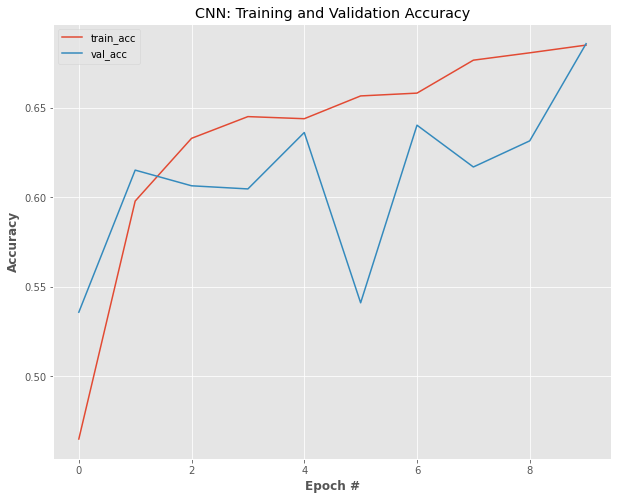

In [ ]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

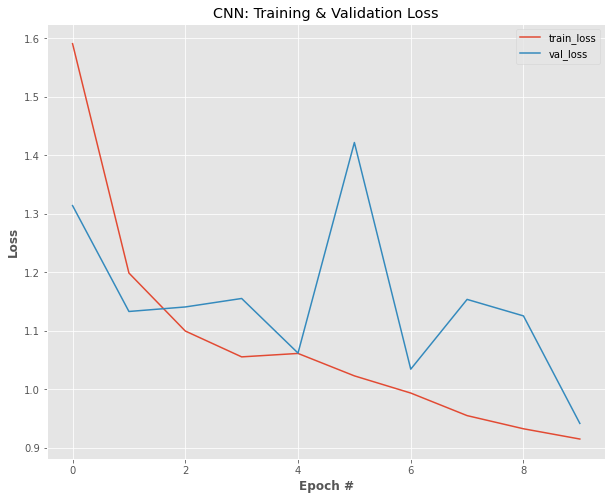

In [ ]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# Model 2

In [ ]:
def model_2(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)))
    
    model.add(Dense(600, kernel_regularizer='l1'))
    model.add(Dense(700, kernel_regularizer='l2'))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model2 = model_2(width=28, height=28, depth=3, classes=11)
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 20)        1520      
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_13 (Activation)   (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)             

In [ ]:
# train the network
print("[INFO] training network...")
H2 = model2.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Train for 160 steps, validate on 1715 samples
Epoch 1/20
160/160 [==============================] - 5s 29ms/step - loss: 21.1291 - accuracy: 0.3992 - val_loss: 2.2680 - val_accuracy: 0.4717
Epoch 2/20
160/160 [==============================] - 4s 28ms/step - loss: 2.1025 - accuracy: 0.4868 - val_loss: 2.0156 - val_accuracy: 0.4939
Epoch 3/20
160/160 [==============================] - 4s 27ms/step - loss: 1.8913 - accuracy: 0.5071 - val_loss: 1.9643 - val_accuracy: 0.4636
Epoch 4/20
160/160 [==============================] - 4s 27ms/step - loss: 1.7674 - accuracy: 0.5330 - val_loss: 1.9566 - val_accuracy: 0.4560
Epoch 5/20
160/160 [==============================] - 4s 27ms/step - loss: 1.6887 - accuracy: 0.5437 - val_loss: 1.6900 - val_accuracy: 0.5411
Epoch 6/20
160/160 [==============================] - 4s 27ms/step - loss: 1.6790 - accuracy: 0.5576 - val_loss: 1.7868 - val_accuracy: 0.5120
Epoch 7/20
160/160 [==============================] - 4s 27ms/step -

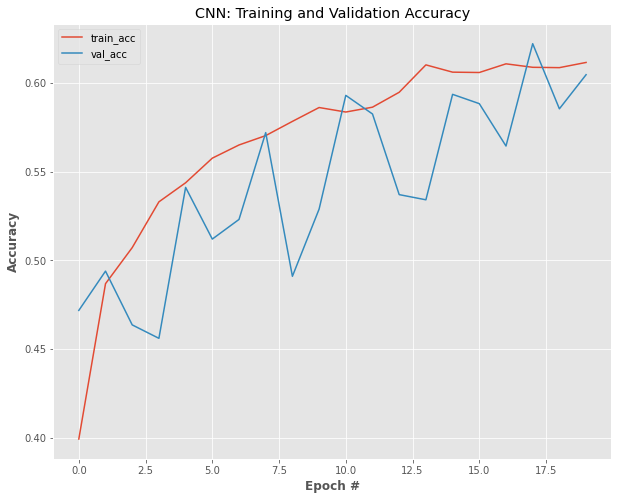

In [ ]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["accuracy"], label="train_acc")
plt.plot(N, H2.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

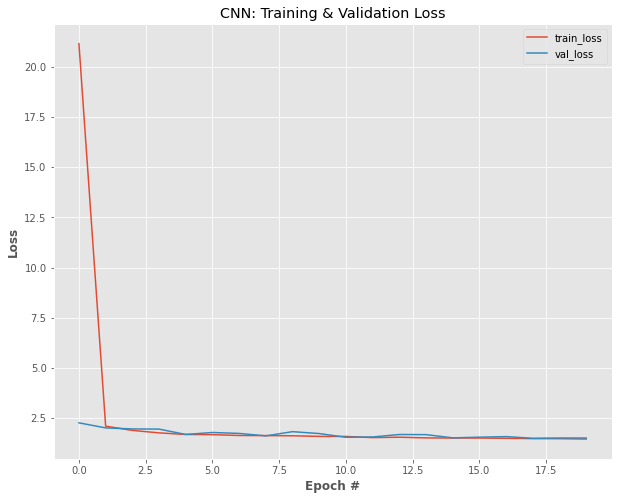

In [ ]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# Homework

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_examples')))   # data folder with 2 categorical folders

all_class = ["Buildings", "Forest", "Sea"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf = model.predict(image)[0]

        # build the label
        label = all_class[np.argmax(prd_conf)]
        proba = prd_conf[np.argmax(prd_conf)]

        label = "{}: {:.2f}%".format(label, proba * 100)

        # draw the label on the image
        output = imutils.resize(orig, width=400)
        cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
            0.7, (255, 0, 0), 2)
        
        # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)
        
        pbar.update(1)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
def predict_image(image):
    # load the image
    
    # pre-process the image for classification
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

        
    preds = model.predict(image)[0]
    result = dict()
    result["Buildings"] = round(float(list(preds)[0]), 3)
    result["Forest"] = round(float(list(preds)[1]), 3)
    result["Sea"] = round(float(list(preds)[2]), 3)
    
    print(result)
    
    return result

In [ ]:
im = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="CNN Demo").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://13520.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fd47ff34410>,
 'http://127.0.0.1:7860/',
 'https://13520.gradio.app')

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0
{'Buildings': 0.0, 'Forest': 0.012, 'Sea': 0.988}
{'Buildings': 0.0, 'Forest': 0.012, 'Sea': 0.988}
